# TDI NUMBER OF RENTAL PREDICTION
1. Defining the problem
2. Exploratory data analysis
    <br> 2.1 Visualizing Categorical Data
    <br> 2.2 Visualizing Numerical Data
3. Data Preprocessing
    <br> 3.1 Outlier Detection Using Boxplot
    <br> 3.2 Outlier Handling
4. Feature Selection
    <br> 4.1 Correlation Analysis for Numerical Variables
    <br> 4.2 Chi-Square Test of Independence For Categorical Variables
    <br> 4.3 Multicollinearity Test
5. Feature Engineering  & Scaling
    <br> 5.1 Feature Engineering On Numeric Variables
    <br> 5.2 Feature Engineering On Categorical Features
    <br> 5.3 Feature Scaling On Numeric Variables
6. Dimensionality Reduction Using PCA
7. Model Building and Evaluation 
8. Summary

## 1. Defining the problem
TDI has the data of number of rentals with some features. They are looking to understand what influences a rental process. For example, could the temperature affect the number of rentals? What is the relationship between target vatiable and predictor variables.

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
import scipy.stats as stats
from fancyimpute import KNN
from patsy import dmatrices
import statsmodels.stats.multicomp

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn import metrics
from math import sqrt

In [2]:
#Impoting Dataset
data = pd.read_csv('tdi_rentals_dataset.csv')
data.head()

,obs,date,season,holiday,working_day,weather_condition,temp,feel_temp,humidity,wind_speed,occasional,members,rental
0,1,2011-01-01,1,0,0,2,14.110847,18.18125,0.805833,10.749882,331,654,985
1,2,2011-01-02,1,0,0,2,14.902598,17.68695,0.696087,16.652113,131,670,801
2,3,2011-01-03,1,0,1,1,8.050924,9.47025,0.437273,16.636703,120,1229,1349
3,4,2011-01-04,1,0,1,1,8.200000,10.60610,0.590435,10.739832,108,1454,1562
4,5,2011-01-05,1,0,1,1,9.305237,11.46350,0.436957,12.522300,82,1518,1600


### The dataset information:
- obs: record index
- date: date
- season: season (1: spring, 2: summer, 3: fall, 4: winter)
- holiday: 1: if the day is a holiday, 0: otherwise
- working_day: 1: if the day is neither weekend nor holiday, 0: otherwise.
- weather_condition: Weather condition (1: clear, 2: cloudy, 3: light rain or snow, 4: heavy rain or snow)
- temp: Temperature in Celsius.
- feel_temp: Feeling temperature in Celsius.
- humidity: Humidity level in percentage.
- wind_speed: Wind speed in miles per hour.
- occasional: Count of rentals from occasional users.
- members: Count of rentals from members.
- rental: Count of total rental including both occasional users and members (main target variable).

In [3]:
data.shape

(731, 13)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   obs                731 non-null    int64  
 1   date               731 non-null    object 
 2   season             731 non-null    int64  
 3   holiday            731 non-null    int64  
 4   working_day        731 non-null    int64  
 5   weather_condition  731 non-null    int64  
 6   temp               731 non-null    float64
 7   feel_temp          731 non-null    float64
 8   humidity           731 non-null    float64
 9   wind_speed         731 non-null    float64
 10  occasional         731 non-null    int64  
 11  members            731 non-null    int64  
 12  rental             731 non-null    int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 74.4+ KB


In [5]:
data.describe()

,obs,season,holiday,working_day,weather_condition,temp,feel_temp,humidity,wind_speed,occasional,members,rental
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.028728,0.683995,1.395349,20.310776,23.717699,0.627894,12.762576,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.167155,0.465233,0.544894,7.505091,8.148059,0.142429,5.192357,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,0.000000,1.000000,13.820424,16.892125,0.520000,9.041650,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,0.000000,1.000000,1.000000,20.431653,24.336650,0.626667,12.125325,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,0.000000,1.000000,2.000000,26.872076,30.430100,0.730209,15.625371,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,1.000000,3.000000,35.328347,42.044800,0.972500,34.000021,3410.000000,6946.000000,8714.000000


By looking at the data, we got to know that it is in the form of timeseries. So, it would be convenient to add month and year to our features before doing exploratory data analysis. We can use pandas to complete this task.   

In [6]:
df1 = data
df1['year'] = pd.DatetimeIndex(df1['date']).year
df1.head()

,obs,date,season,holiday,working_day,weather_condition,temp,feel_temp,humidity,wind_speed,occasional,members,rental,year
0,1,2011-01-01,1,0,0,2,14.110847,18.18125,0.805833,10.749882,331,654,985,2011
1,2,2011-01-02,1,0,0,2,14.902598,17.68695,0.696087,16.652113,131,670,801,2011
2,3,2011-01-03,1,0,1,1,8.050924,9.47025,0.437273,16.636703,120,1229,1349,2011
3,4,2011-01-04,1,0,1,1,8.200000,10.60610,0.590435,10.739832,108,1454,1562,2011
4,5,2011-01-05,1,0,1,1,9.305237,11.46350,0.436957,12.522300,82,1518,1600,2011


In [7]:
df1['month'] = pd.DatetimeIndex(df1['date']).month
df1.head()

,obs,date,season,holiday,working_day,weather_condition,temp,feel_temp,humidity,wind_speed,occasional,members,rental,year,month
0,1,2011-01-01,1,0,0,2,14.110847,18.18125,0.805833,10.749882,331,654,985,2011,1
1,2,2011-01-02,1,0,0,2,14.902598,17.68695,0.696087,16.652113,131,670,801,2011,1
2,3,2011-01-03,1,0,1,1,8.050924,9.47025,0.437273,16.636703,120,1229,1349,2011,1
3,4,2011-01-04,1,0,1,1,8.200000,10.60610,0.590435,10.739832,108,1454,1562,2011,1
4,5,2011-01-05,1,0,1,1,9.305237,11.46350,0.436957,12.522300,82,1518,1600,2011,1


In [8]:
#Reordeing columns and dropping date and obs
df2 = df1[['month','year','season','holiday','working_day','weather_condition','temp','feel_temp','humidity','wind_speed','occasional', 'members', 'rental']]
df2.head()

,month,year,season,holiday,working_day,weather_condition,temp,feel_temp,humidity,wind_speed,occasional,members,rental
0,1,2011,1,0,0,2,14.110847,18.18125,0.805833,10.749882,331,654,985
1,1,2011,1,0,0,2,14.902598,17.68695,0.696087,16.652113,131,670,801
2,1,2011,1,0,1,1,8.050924,9.47025,0.437273,16.636703,120,1229,1349
3,1,2011,1,0,1,1,8.200000,10.60610,0.590435,10.739832,108,1454,1562
4,1,2011,1,0,1,1,9.305237,11.46350,0.436957,12.522300,82,1518,1600


In [9]:
#Checking Null Values in the dataset
pd.DataFrame(df2.isnull().sum())

,0
month,0
year,0
season,0
holiday,0
working_day,0
weather_condition,0
temp,0
feel_temp,0
humidity,0
wind_speed,0


In [10]:
#Dividing into Numerical (Continuous) and Categorical features.
df_num = df2[['temp','feel_temp','humidity','wind_speed','occasional', 'members','rental']]
df_cat = df2[['month','year','season','holiday','working_day','weather_condition']]
df_num.head()

,temp,feel_temp,humidity,wind_speed,occasional,members,rental
0,14.110847,18.18125,0.805833,10.749882,331,654,985
1,14.902598,17.68695,0.696087,16.652113,131,670,801
2,8.050924,9.47025,0.437273,16.636703,120,1229,1349
3,8.200000,10.60610,0.590435,10.739832,108,1454,1562
4,9.305237,11.46350,0.436957,12.522300,82,1518,1600


## 2. Exploratory Data Analysis

### 2.1 Visualizing Categorical Data

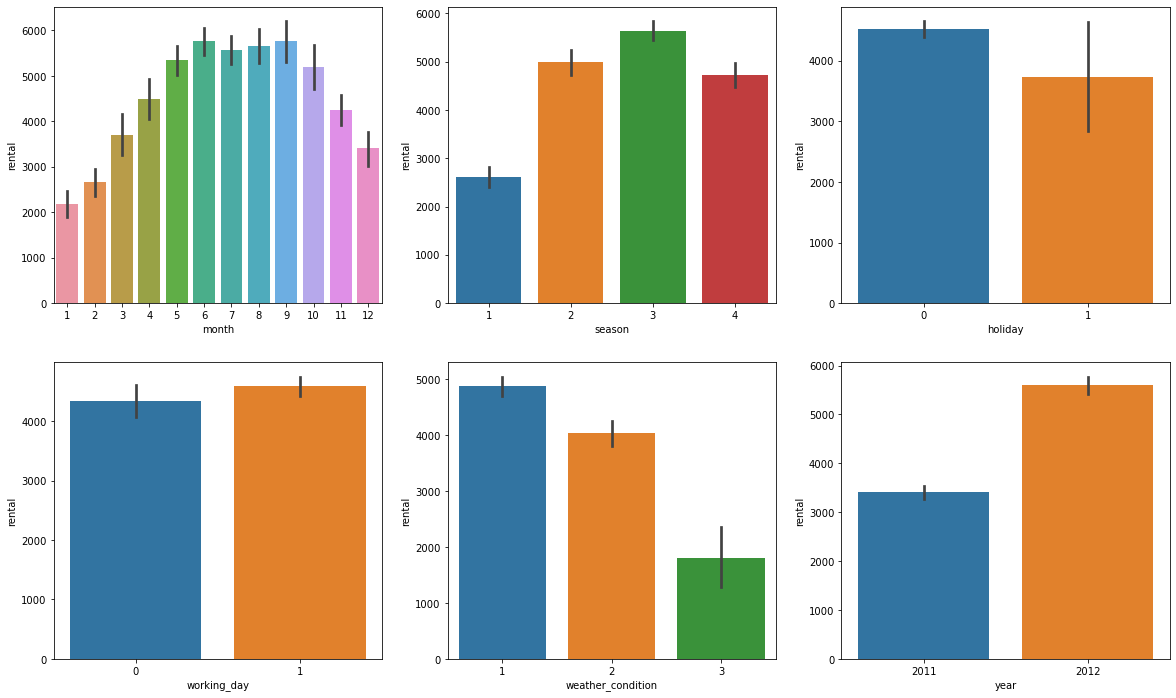

In [11]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.barplot(x = 'month', y = 'rental', data = df2)
plt.subplot(2,3,2)
sns.barplot(x = 'season', y = 'rental', data = df2)
plt.subplot(2,3,3)
sns.barplot(x = 'holiday', y = 'rental', data = df2)
plt.subplot(2,3,4)
sns.barplot(x = 'working_day', y = 'rental', data = df2)
plt.subplot(2,3,5)
sns.barplot(x = 'weather_condition', y = 'rental', data = df2)
plt.subplot(2,3,6)
sns.barplot(x = 'year', y = 'rental', data = df2)
plt.show()

### Findings:
- The average number of rentals gentaly increase from January to July and then starting to get decreased from July to December. 

- The number of rentals is least for Spring (Season 1) and most for Fall (Season 3). 

- The number of rentals incresed in year 2012.

- The number of rentals has zero values for weather situation - 'Heavy rain or Snow'(cat no 4)

- The number of rentals are less during holidays.

- Weather conditions do play a crucial role in deciding the number rentals. During bad weather, less people are going to using rentals. Clear weather on the other hand attracts more people to use rentals.

### 2.2 Visualizing Numerical Data

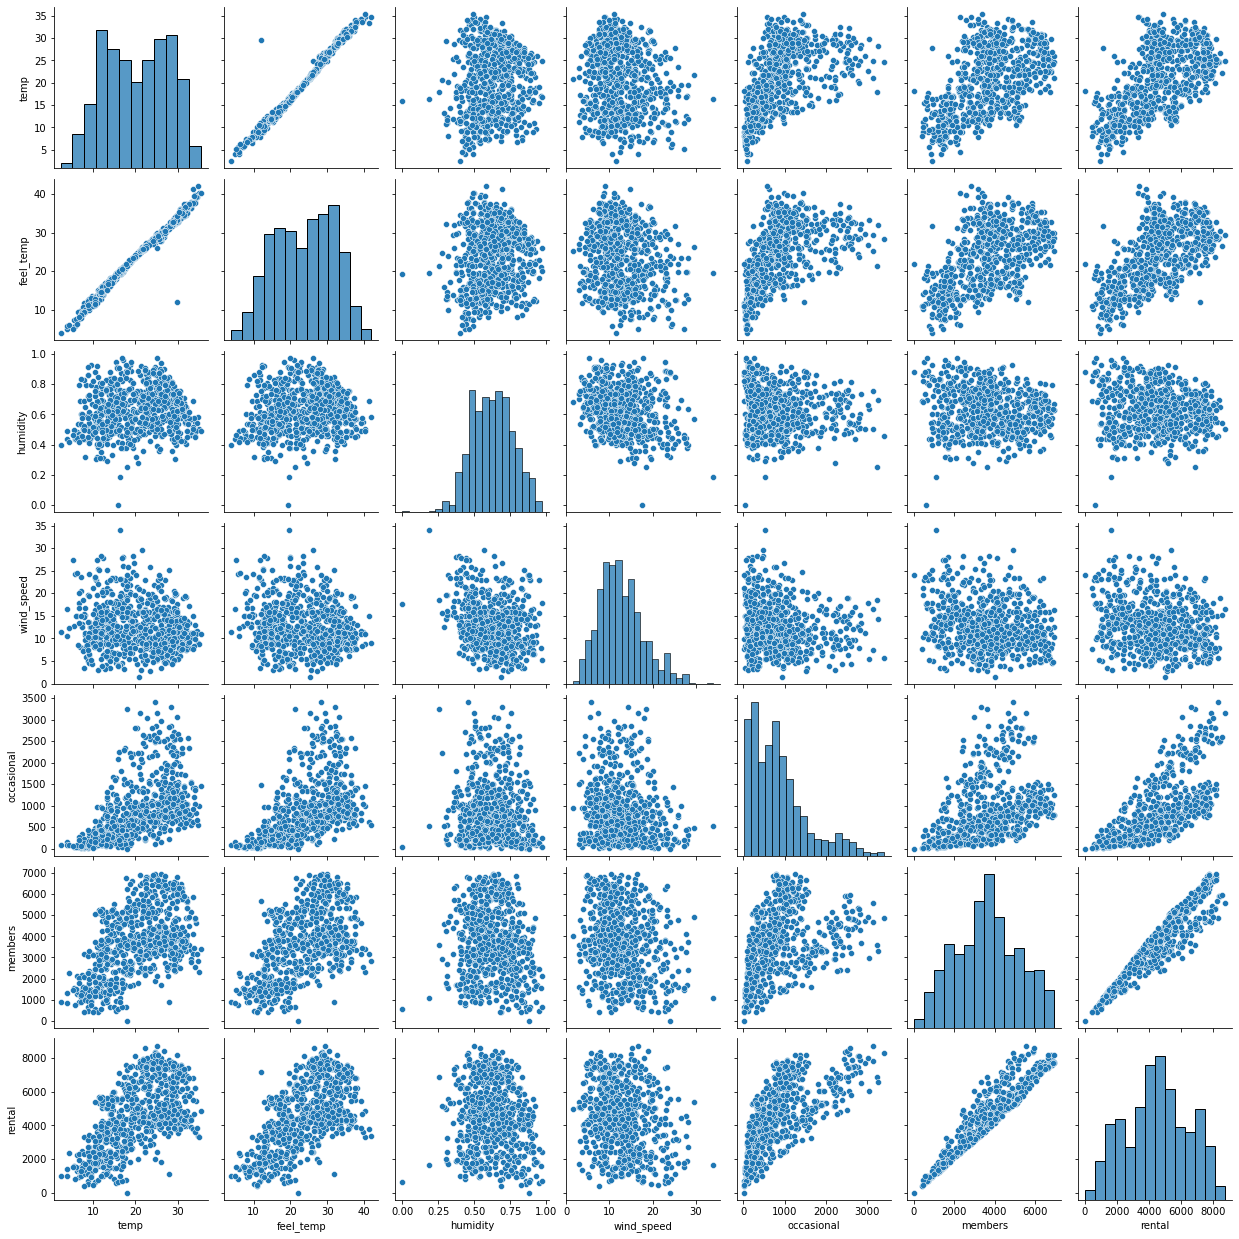

In [12]:
sns.pairplot(data=df_num,kind='scatter')

### Findings:
- There is a strong positive correlation between 'temp' and 'feel_temp'. 

- There is also a positive correlation between 'members' and 'rental'. 

- There is also a weak positive correlation between 'temp' and 'rental'. A higher temperature would probably suggest a better weather condition, and hence the number of rentals increase.


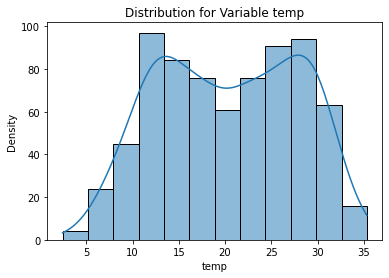

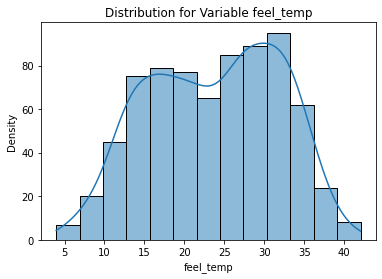

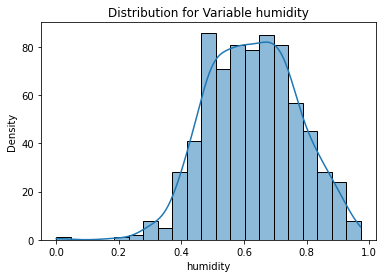

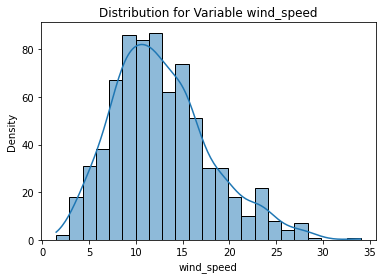

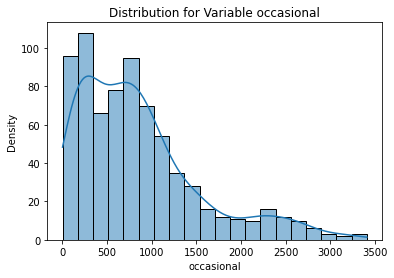

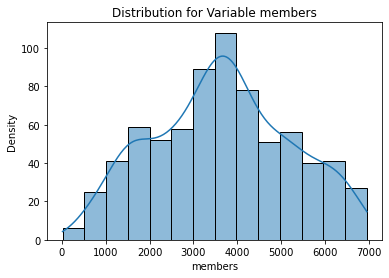

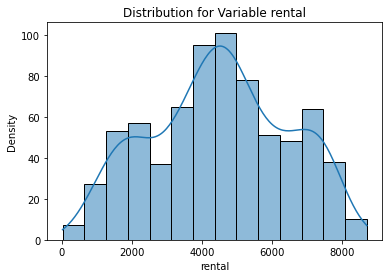

In [13]:
#Variable Density Distribution
for i in df_num.columns:
    sns.histplot(df2[i],bins='auto', kde=True)
    plt.title("Distribution for Variable "+i)
    plt.ylabel("Density")
    plt.show()

### Findings:
- Density Distrubtion is almost same for 'temp' and 'feel_temp'. 

- Density Distrubtion is almost same for 'members' and 'rental'. 

- 'Occasional' feature has right - skewed data distribution. 


## 3. Data Preprocessing
### 3.1 Outlier Detection Using Boxplot
Let's now check for outliers in our dataset. 
<br>Univariate Boxplots: Boxplots for all Numerical Variables including target variable.

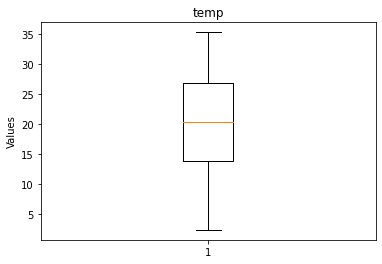

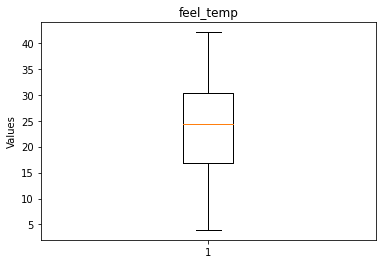

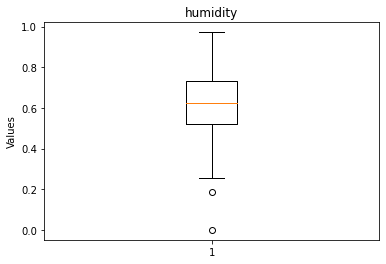

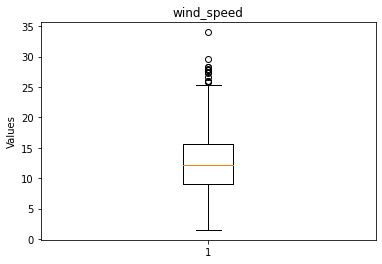

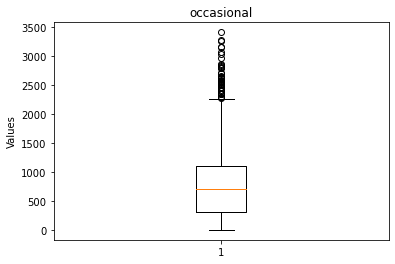

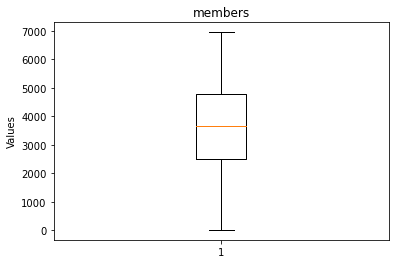

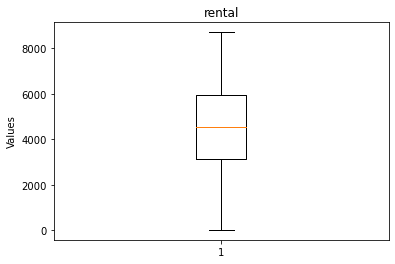

In [14]:
for i in df_num.columns:
    plt.boxplot(df_num[i])
    plt.title(i)
    plt.ylabel('Values')
    plt.show()


<br> As we can see from the above Boxplots only 'humidity', 'wind_speed' and 'occasional' features are having outliers. 
<br> We already know that our target varialbe is rental and 'rental' = 'occasional' + 'member'.
<br> So we need to handle outliers from 'humidity' and 'wind_speed'.

### 3.2 Outlier Handling

In [15]:
print("Standard Deviation before Outlier Handling")
df2[['humidity', 'wind_speed']].std()

Standard Deviation before Outlier Handling


humidity      0.142429
wind_speed    5.192357
dtype: float64

In [16]:
def outlier_treatment(col):
    #Extract quartiles
    q75, q25 = np.percentile(df2[col], [75 ,25])
    #Calculate IQR
    iqr = q75 - q25
    #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    #Replace with NA
    df2.loc[df2[col] < minimum,col] = np.nan
    df2.loc[df2[col] > maximum,col] = np.nan
    
    df2.loc[df2[col]< minimum,col] = np.nan
    df2.loc[df2[col]> maximum,col] = np.nan
    
outlier_treatment('humidity')
outlier_treatment('wind_speed')
# Checking % of missing values
df2.isnull().sum()


C:\Users\anujk\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


month                 0
year                  0
season                0
holiday               0
working_day           0
weather_condition     0
temp                  0
feel_temp             0
humidity              2
wind_speed           13
occasional            0
members               0
rental                0
dtype: int64

I have checked standard deviation for 3 imputation methods-mean,median,KNN and standard deviation remains nearly same with KNN imputation. So, I choose KNN for imputation method.
<br>And I have also checked standard deviation for different values of K for KNN and I have selected K=3 for 'humidity' and K=1 for 'wind_speed'.

In [17]:
#Imputing with missing values using KNN
df2 = pd.DataFrame(KNN(k = 3).fit_transform(df2), columns = df2.columns, index=df2.index)
df2.isnull().sum()

Imputing row 1/731 with 0 missing, elapsed time: 0.074
Imputing row 101/731 with 0 missing, elapsed time: 0.074
Imputing row 201/731 with 0 missing, elapsed time: 0.075
Imputing row 301/731 with 0 missing, elapsed time: 0.075
Imputing row 401/731 with 0 missing, elapsed time: 0.075
Imputing row 501/731 with 0 missing, elapsed time: 0.075
Imputing row 601/731 with 0 missing, elapsed time: 0.076
Imputing row 701/731 with 0 missing, elapsed time: 0.076


month                0
year                 0
season               0
holiday              0
working_day          0
weather_condition    0
temp                 0
feel_temp            0
humidity             0
wind_speed           0
occasional           0
members              0
rental               0
dtype: int64

In [18]:
print("Standard Deviation After Outlier Handling")
df2[['humidity', 'wind_speed']].std()

Standard Deviation After Outlier Handling


humidity      0.140024
wind_speed    4.784161
dtype: float64

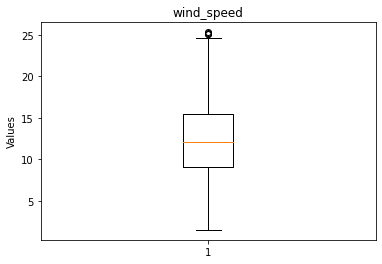

In [19]:
plt.boxplot(df2['wind_speed'])
plt.title('wind_speed')
plt.ylabel('Values')
plt.show()

In [20]:
df2.head()

,month,year,season,holiday,working_day,weather_condition,temp,feel_temp,humidity,wind_speed,occasional,members,rental
0,1.0,2011.0,1.0,0.0,0.0,2.0,14.110847,18.18125,0.805833,10.749882,331.0,654.0,985.0
1,1.0,2011.0,1.0,0.0,0.0,2.0,14.902598,17.68695,0.696087,16.652113,131.0,670.0,801.0
2,1.0,2011.0,1.0,0.0,1.0,1.0,8.050924,9.47025,0.437273,16.636703,120.0,1229.0,1349.0
3,1.0,2011.0,1.0,0.0,1.0,1.0,8.200000,10.60610,0.590435,10.739832,108.0,1454.0,1562.0
4,1.0,2011.0,1.0,0.0,1.0,1.0,9.305237,11.46350,0.436957,12.522300,82.0,1518.0,1600.0


## 4. Feature Selection
### 4.1 Correlation Analysis for Numerical Variables/Features </br>
<li>We need to plot the heat map of corelation  to measure how strongly 2 variables are related to each other.
<li>We have to check for correlation to avoid redundant information in our model development.

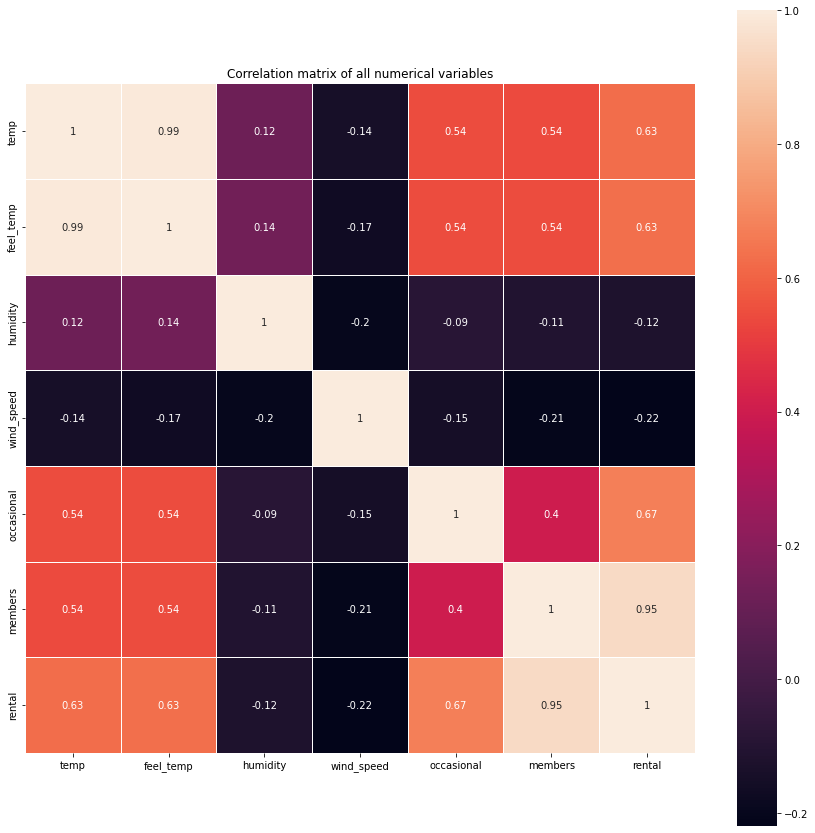

In [21]:
# heatmap using correlation matrix
plt.figure(figsize=(15,15))
_ = sns.heatmap(df2[df_num.columns].corr(),linewidths=0.5,linecolor='w',square=True,annot=True)
plt.title('Correlation matrix of all numerical variables')
plt.show()

### Findings:
<ul>
<li>'temp' and 'feel_temp' are very highly correlated with each other.</li>
<li>similarly, 'members' and 'rental' are highly correlated with each other.</li>
<li>We already established that 'rental'='members'+'occasional'</li>
</ul>

### 4.2 Chi-square test of Independence for Categorical Variables/Features
- Hypothesis testing => Null Hypothesis = 2 variables are independent.
<li> Alternate Hypothesis = 2 variables are not independent.
<li>If p-value is less than 0.05 then we reject the null hypothesis saying that 2 variables are dependent.
<li>And if p-value is greater than 0.05 then we accept the null hypothesis saying that 2 variables are independent.
<li>There should be no dependencies between Independent variables.
<li>So we will remove that variable whose p-value with other variable is low than 0.05.
<li>And we will keep that variable whose p-value with other variable is high than 0.05

In [22]:
#loop for chi square values
for i in df_cat:
    for j in df_cat:
        if(i != j):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(df2[i], df2[j]))
            if(p < 0.05):
                print(i,"and",j,"are dependent on each other with",p,'----Remove')
            else:
                print(i,"and",j,"are independent on each other with",p,'----Keep')

month and year are independent on each other with 0.9999999999999892 ----Keep
month and season are dependent on each other with 0.0 ----Remove
month and holiday are independent on each other with 0.5593083086035064 ----Keep
month and working_day are independent on each other with 0.9933495217919545 ----Keep
month and weather_condition are dependent on each other with 0.014637111771019196 ----Remove
year and month are independent on each other with 0.9999999999999892 ----Keep
year and season are independent on each other with 0.9999288084245916 ----Keep
year and holiday are independent on each other with 1.0 ----Keep
year and working_day are independent on each other with 1.0 ----Keep
year and weather_condition are independent on each other with 0.12737941480418666 ----Keep
season and month are dependent on each other with 0.0 ----Remove
season and year are independent on each other with 0.9999288084245916 ----Keep
season and holiday are independent on each other with 0.6831687073042003

According to Chi-Square test, we have to remove month, working_day, weather_condition.

In [23]:
df3 = df2.drop(['month', 'holiday', 'weather_condition'], axis = 1)
df3.head()

,year,season,working_day,temp,feel_temp,humidity,wind_speed,occasional,members,rental
0,2011.0,1.0,0.0,14.110847,18.18125,0.805833,10.749882,331.0,654.0,985.0
1,2011.0,1.0,0.0,14.902598,17.68695,0.696087,16.652113,131.0,670.0,801.0
2,2011.0,1.0,1.0,8.050924,9.47025,0.437273,16.636703,120.0,1229.0,1349.0
3,2011.0,1.0,1.0,8.200000,10.60610,0.590435,10.739832,108.0,1454.0,1562.0
4,2011.0,1.0,1.0,9.305237,11.46350,0.436957,12.522300,82.0,1518.0,1600.0


In [24]:
df3.dtypes

year           float64
season         float64
working_day    float64
temp           float64
feel_temp      float64
humidity       float64
wind_speed     float64
occasional     float64
members        float64
rental         float64
dtype: object

In [25]:
df3[['season', 'working_day', 'year']] = df3[['season', 'working_day', 'year']].astype('category')
df3.dtypes

year           category
season         category
working_day    category
temp            float64
feel_temp       float64
humidity        float64
wind_speed      float64
occasional      float64
members         float64
rental          float64
dtype: object

### 4.3 Multicollinearity Test 
<li>VIF(Variance Inflation Factor) is always greater or equal to 1.
<li>if VIF is 1 --- Not correlated to any of the variables.
<li>if VIF is between 1-5 --- Moderately correlated.
<li>if VIF is above 5 --- Highly correlated.
<li>If there are multiple variables with VIF greater than 5, only remove the variable with the highest VIF.

In [26]:
outcome, predictors = dmatrices('rental ~ +season+ year +working_day+ temp+feel_temp + humidity + wind_speed',df3, return_type='dataframe')

# calculating VIF for each individual Predictors
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

,VIF,features
0,51.291084,Intercept
1,2.620337,season[T.2.0]
2,4.638388,season[T.3.0]
3,1.840558,season[T.4.0]
4,1.029073,year[T.2012.0]
5,1.004135,working_day[T.1.0]
6,70.089337,temp
7,66.185987,feel_temp
8,1.112303,humidity
9,1.138083,wind_speed


From above Dataframe we see that there is Multicollinearity in our Data
<br> Temp and Feel_temp has highest VIF value

## 5. Feature Engineering & Scaling
### 5.1 Feature Engineering on Numeric Variables
We know that temp and feel_temp are both temperature values and are very highly correlated with each other.
<br>So we need to aggregate those 2 columns and derived a new feature called 'mean_temp'.

In [27]:
df3['mean_temp'] = df3.apply(lambda row: row[['temp', 'feel_temp']].mean(), axis=1)
df3.head()

,year,season,working_day,temp,feel_temp,humidity,wind_speed,occasional,members,rental,mean_temp
0,2011.0,1.0,0.0,14.110847,18.18125,0.805833,10.749882,331.0,654.0,985.0,16.146048
1,2011.0,1.0,0.0,14.902598,17.68695,0.696087,16.652113,131.0,670.0,801.0,16.294774
2,2011.0,1.0,1.0,8.050924,9.47025,0.437273,16.636703,120.0,1229.0,1349.0,8.760587
3,2011.0,1.0,1.0,8.200000,10.60610,0.590435,10.739832,108.0,1454.0,1562.0,9.403050
4,2011.0,1.0,1.0,9.305237,11.46350,0.436957,12.522300,82.0,1518.0,1600.0,10.384369


In [28]:
#Changing the order of columns
df4 = df3[['season','year','working_day', 'mean_temp', 'humidity','wind_speed','occasional','members','rental']]
df4.head()

,season,year,working_day,mean_temp,humidity,wind_speed,occasional,members,rental
0,1.0,2011.0,0.0,16.146048,0.805833,10.749882,331.0,654.0,985.0
1,1.0,2011.0,0.0,16.294774,0.696087,16.652113,131.0,670.0,801.0
2,1.0,2011.0,1.0,8.760587,0.437273,16.636703,120.0,1229.0,1349.0
3,1.0,2011.0,1.0,9.403050,0.590435,10.739832,108.0,1454.0,1562.0
4,1.0,2011.0,1.0,10.384369,0.436957,12.522300,82.0,1518.0,1600.0


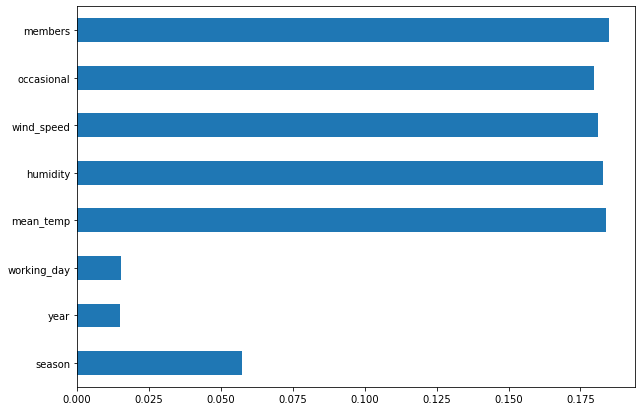

In [29]:
#feature importance
from sklearn.ensemble import ExtraTreesClassifier
temp_X_train = df4.drop(['rental'], axis=1)
temp_y_train = df4['rental']
etc = ExtraTreesClassifier()
etc.fit(temp_X_train, temp_y_train)

plt.figure(figsize=(10,7))
feature_score = pd.Series(etc.feature_importances_, index=temp_X_train.columns)
feature_score.plot(kind='barh')
plt.show()

### 5.2 Feature Engineering On Categorical Features
We will use one-hot encoding techniques on categorical variables - season, year, working_day.

In [30]:
df4.head()

,season,year,working_day,mean_temp,humidity,wind_speed,occasional,members,rental
0,1.0,2011.0,0.0,16.146048,0.805833,10.749882,331.0,654.0,985.0
1,1.0,2011.0,0.0,16.294774,0.696087,16.652113,131.0,670.0,801.0
2,1.0,2011.0,1.0,8.760587,0.437273,16.636703,120.0,1229.0,1349.0
3,1.0,2011.0,1.0,9.403050,0.590435,10.739832,108.0,1454.0,1562.0
4,1.0,2011.0,1.0,10.384369,0.436957,12.522300,82.0,1518.0,1600.0


In [31]:
df5 = pd.get_dummies(data = df4, columns = ['season','year','working_day'])
df5.head()

,mean_temp,humidity,wind_speed,occasional,members,rental,season_1.0,season_2.0,season_3.0,season_4.0,year_2011.0,year_2012.0,working_day_0.0,working_day_1.0
0,16.146048,0.805833,10.749882,331.0,654.0,985.0,1,0,0,0,1,0,1,0
1,16.294774,0.696087,16.652113,131.0,670.0,801.0,1,0,0,0,1,0,1,0
2,8.760587,0.437273,16.636703,120.0,1229.0,1349.0,1,0,0,0,1,0,0,1
3,9.403050,0.590435,10.739832,108.0,1454.0,1562.0,1,0,0,0,1,0,0,1
4,10.384369,0.436957,12.522300,82.0,1518.0,1600.0,1,0,0,0,1,0,0,1


In [32]:
y = df5['rental']
x  = df5.drop(['rental','occasional','members'] , axis = 'columns')
x.head()

,mean_temp,humidity,wind_speed,season_1.0,season_2.0,season_3.0,season_4.0,year_2011.0,year_2012.0,working_day_0.0,working_day_1.0
0,16.146048,0.805833,10.749882,1,0,0,0,1,0,1,0
1,16.294774,0.696087,16.652113,1,0,0,0,1,0,1,0
2,8.760587,0.437273,16.636703,1,0,0,0,1,0,0,1
3,9.403050,0.590435,10.739832,1,0,0,0,1,0,0,1
4,10.384369,0.436957,12.522300,1,0,0,0,1,0,0,1


### 5.3 Feature Scaling On Numeric Variables
Before we move to Feature Scaling, we need to split the dataset into train and test to avoid the infomation leakage.

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)
x_train.head()

,mean_temp,humidity,wind_speed,season_1.0,season_2.0,season_3.0,season_4.0,year_2011.0,year_2012.0,working_day_0.0,working_day_1.0
172,32.379052,0.707500,11.541554,0,0,1,0,1,0,0,1
142,27.706574,0.810000,15.667414,0,1,0,0,1,0,0,1
237,30.843325,0.761250,5.625488,0,0,1,0,1,0,0,1
531,28.096773,0.589583,11.833339,0,1,0,0,0,1,0,1
487,25.012823,0.797083,9.249886,0,1,0,0,0,1,0,1


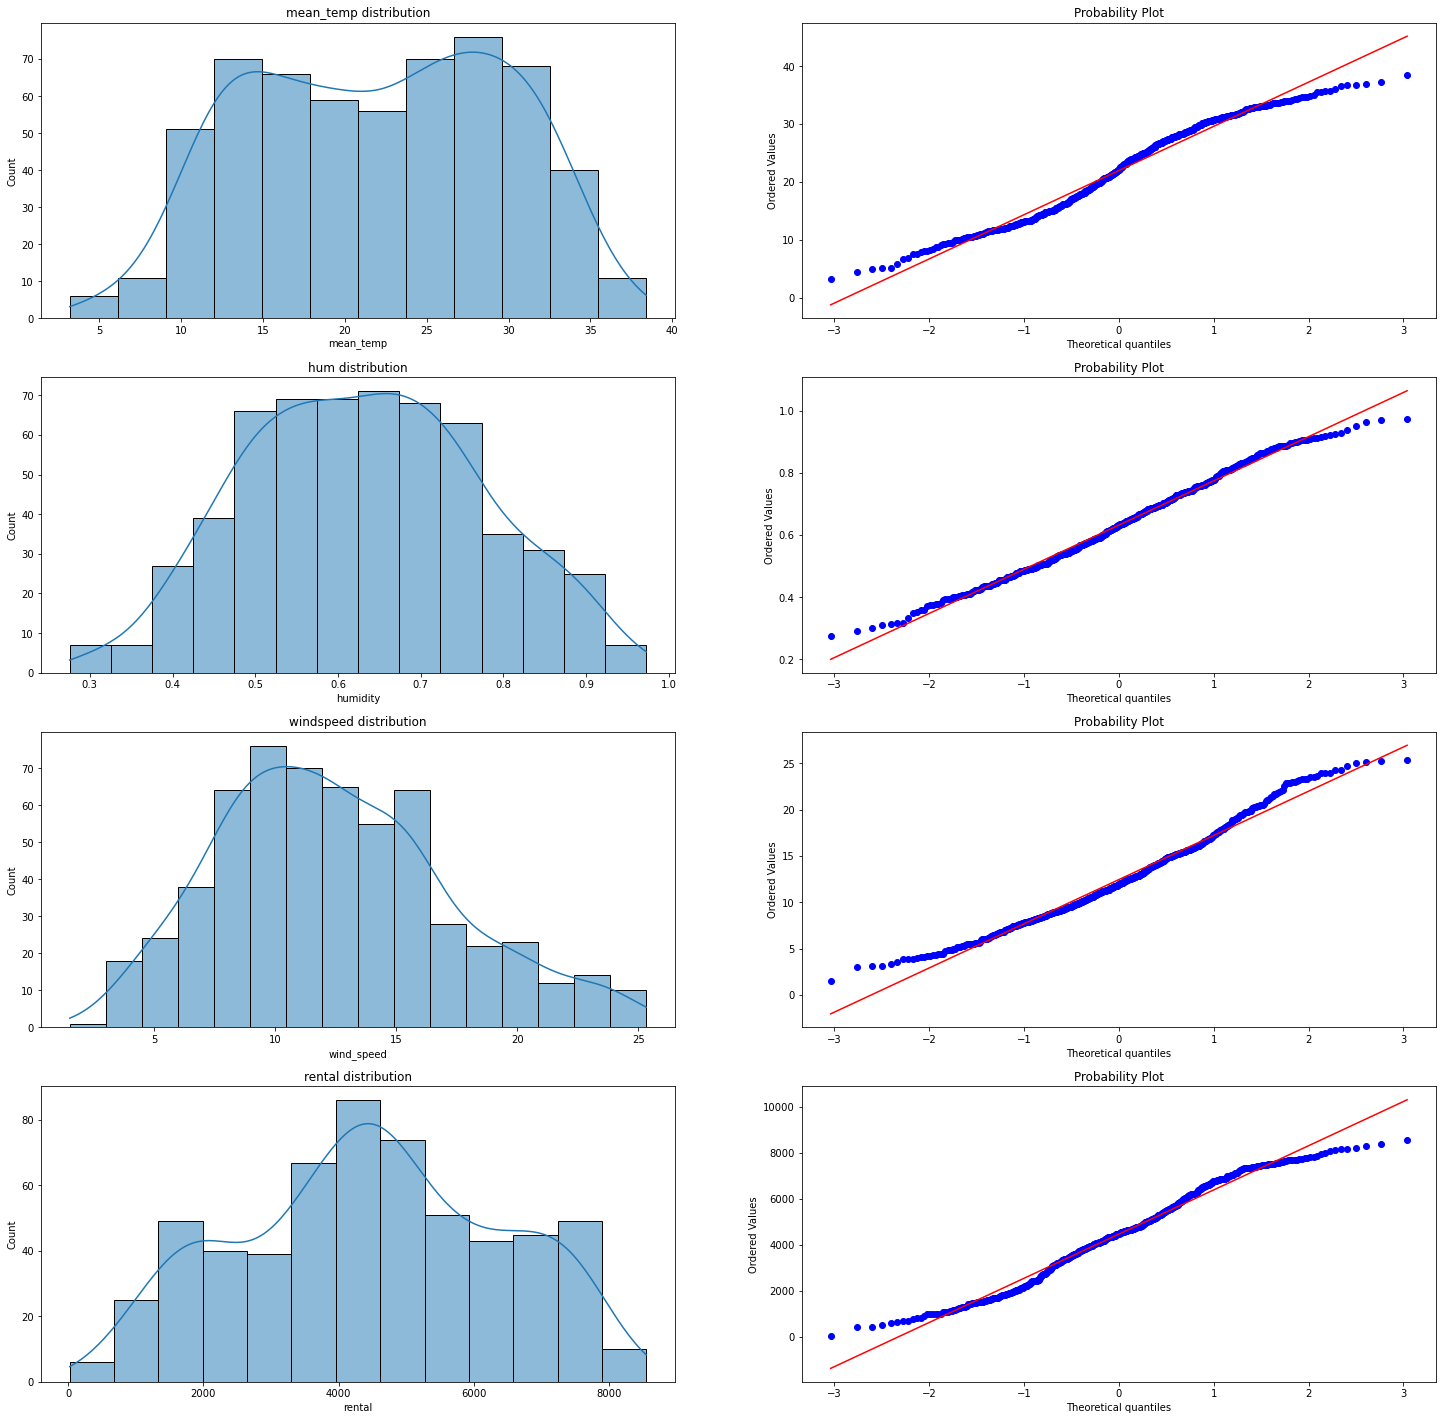

In [34]:
fig,ax = plt.subplots(nrows=4,ncols=2)
fig.set_size_inches(25, 25)
sns.histplot(x_train['mean_temp'],bins = 'auto',ax = ax[0][0], kde=True)
ax[0][0].set(title="mean_temp distribution")
_ = stats.probplot(x_train['mean_temp'], dist='norm', fit=True,plot=ax[0][1])
ax[0][1].set(title="Probability Plot")

sns.histplot(x_train['humidity'],bins = 'auto',ax = ax[1][0],kde=True)
ax[1][0].set(title="hum distribution")
_ = stats.probplot(x_train['humidity'], dist='norm', fit=True,plot=ax[1][1])
ax[1][1].set(title="Probability Plot")

sns.histplot(x_train['wind_speed'],bins = 'auto' ,ax = ax[2][0],kde=True)
ax[2][0].set(title="windspeed distribution")
_ = stats.probplot(x_train['wind_speed'], dist='norm', fit=True,plot=ax[2][1])
ax[2][1].set(title="Probability Plot")

sns.histplot(y_train,bins = 'auto',ax = ax[3][0],kde=True)
ax[3][0].set(title="rental distribution")
_ = stats.probplot(y_train, dist='norm', fit=True,plot=ax[3][1])
ax[3][1].set(title="Probability Plot")

plt.show()

In [35]:
sc = MinMaxScaler()
x_train[['mean_temp','humidity','wind_speed']] = sc.fit_transform(x_train[['mean_temp','humidity','wind_speed']])
x_test[['mean_temp','humidity','wind_speed']] = sc.fit_transform(x_test[['mean_temp','humidity','wind_speed']])
x_train.head()


C:\Users\anujk\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\anujk\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,mean_temp,humidity,wind_speed,season_1.0,season_2.0,season_3.0,season_4.0,year_2011.0,year_2012.0,working_day_0.0,working_day_1.0
172,0.828693,0.619617,0.421320,0,0,1,0,1,0,0,1
142,0.696044,0.766747,0.594435,0,1,0,0,1,0,0,1
237,0.785094,0.696770,0.173090,0,0,1,0,1,0,0,1
531,0.707121,0.450359,0.433563,0,1,0,0,0,1,0,1
487,0.619570,0.748205,0.325164,0,1,0,0,0,1,0,1


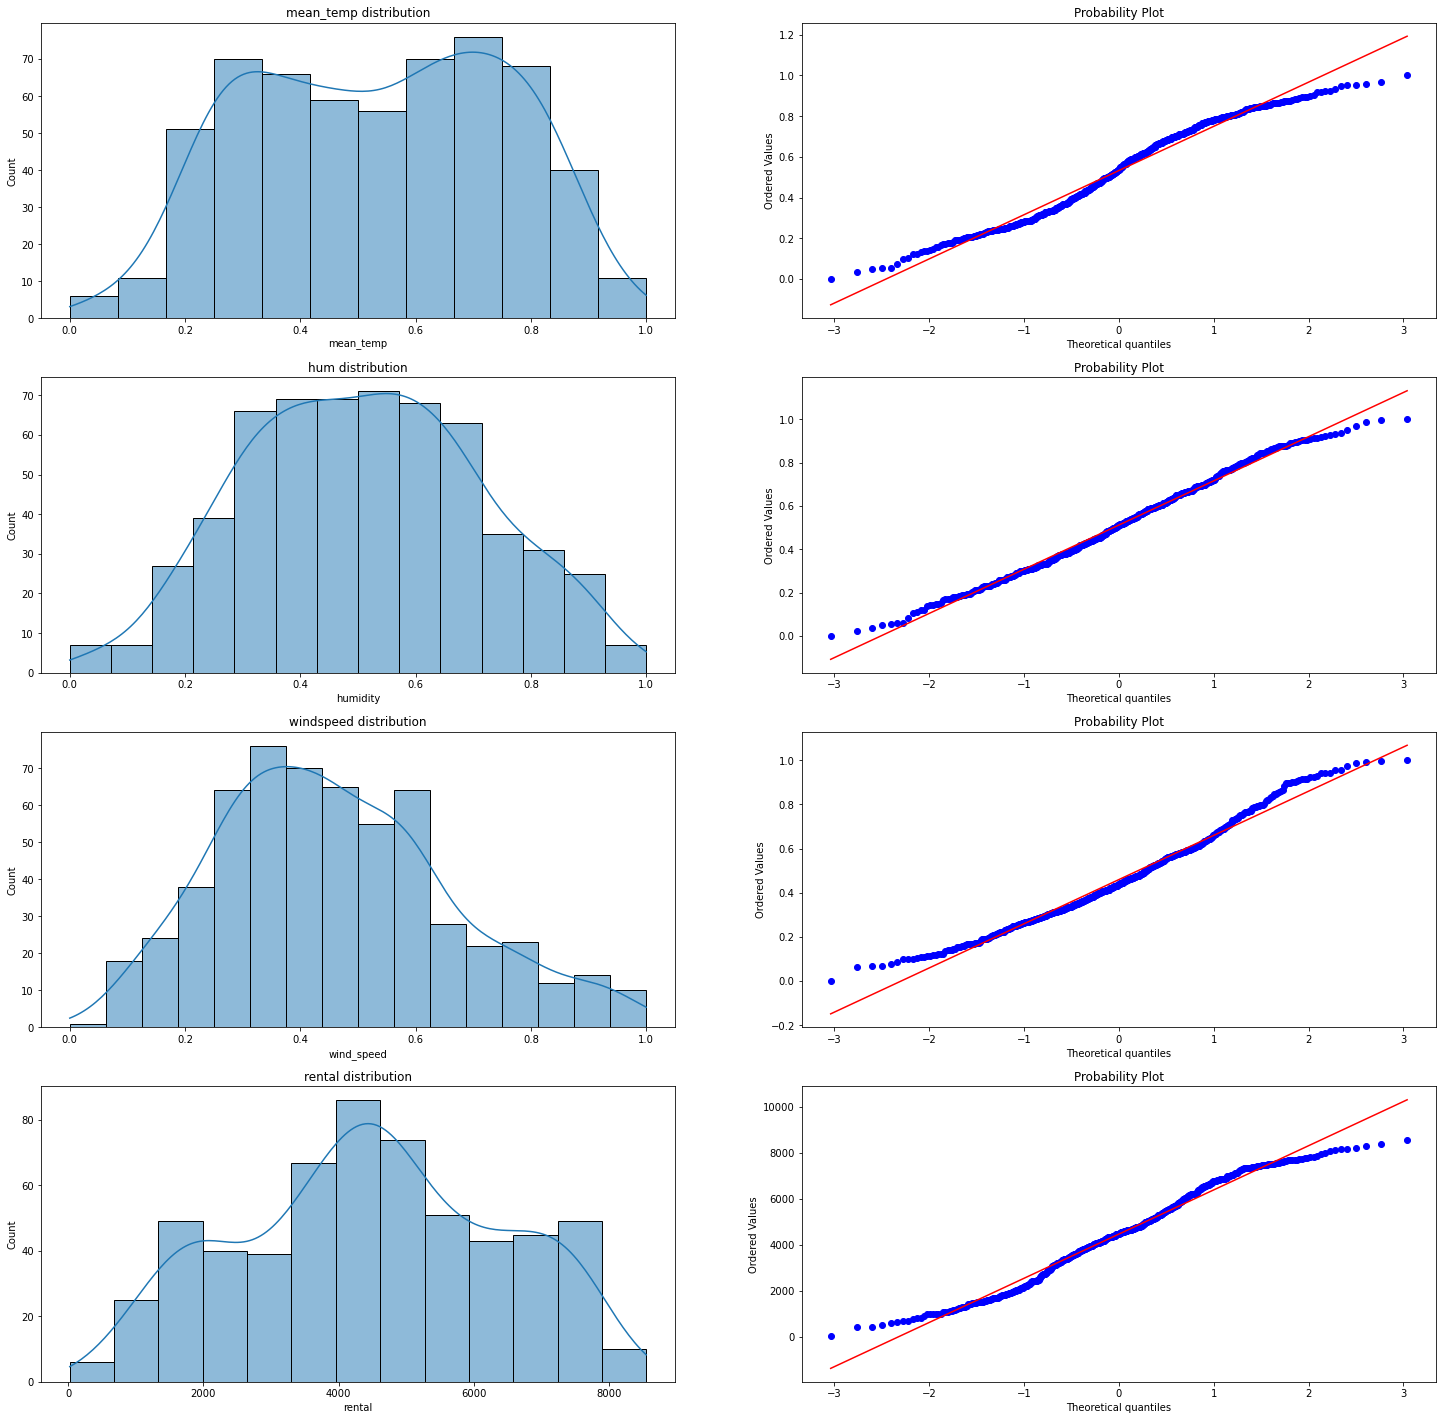

In [36]:
fig,ax = plt.subplots(nrows=4,ncols=2)
fig.set_size_inches(25, 25)
sns.histplot(x_train['mean_temp'],bins = 'auto' ,ax = ax[0][0], kde=True)
ax[0][0].set(title="mean_temp distribution")
_ = stats.probplot(x_train['mean_temp'], dist='norm', fit=True,plot=ax[0][1])
ax[0][1].set(title="Probability Plot")

sns.histplot(x_train['humidity'],bins ='auto',ax = ax[1][0],kde=True)
ax[1][0].set(title="hum distribution")
_ = stats.probplot(x_train['humidity'], dist='norm', fit=True,plot=ax[1][1])
ax[1][1].set(title="Probability Plot")

sns.histplot(x_train['wind_speed'],bins ='auto',ax = ax[2][0],kde=True)
ax[2][0].set(title="windspeed distribution")
_ = stats.probplot(x_train['wind_speed'], dist='norm', fit=True,plot=ax[2][1])
ax[2][1].set(title="Probability Plot")

sns.histplot(y_train,bins ='auto',ax = ax[3][0],kde=True)
ax[3][0].set(title="rental distribution")
_ = stats.probplot(y_train, dist='norm', fit=True,plot=ax[3][1])
ax[3][1].set(title="Probability Plot")

plt.show()

## 6. Dimensionality Reduction Using PCA
PCA is used to reduce the dimensionality.Dimensionality reduction involves reducing the number of input variables or columns in modeling data. PCA is a technique from linear algebra that can be used to automatically perform dimensionality reduction.

[ 27.86  51.43  66.88  81.17  94.98  97.49  99.25 100.   100.   100.
 100.  ]


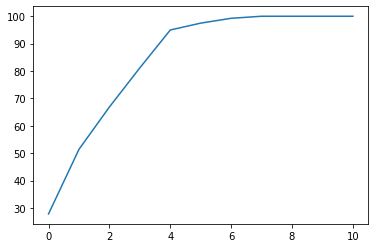

In [37]:
pca = PCA()
pca.fit(x_train)
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)
plt.plot(var1)
plt.show()

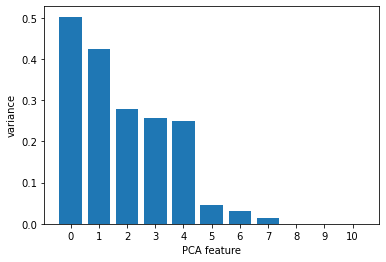

In [38]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

<br> The intrinsic dimension is the number of PCA features with significant variance.
<br> So from the above barplot: intrinsic dimension = 8.
<br> Now we have reduced the dimension of our data.

In [39]:
pca = PCA(n_components=8)
pca.fit(x_train)

PCA(n_components=8)

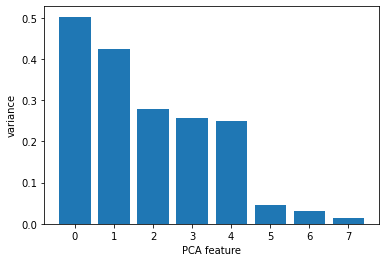

In [40]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [41]:
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

In [42]:
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(584, 8) (584,)
(147, 8) (147,)


## 7.Model Building and Evaluation
Below are some common Evaluation Metrics used to evaluate model performace.
1. R Square/Adjusted R Square : R Square measures how much variability in dependent variable can be explained by the model. 
2. MSE : While R Square is a relative measure of how well the model fits dependent variables, Mean Square Error is an absolute measure of the goodness for the fit.
3. RMSE : As RMSE is clear by the name itself, that it is a simple square root of mean squared error.
4. RMSLE : It is the Root Mean Squared Error of the log-transformed predicted and log-transformed actual values.

In [43]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-x_train.shape[1]-1)))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('------------------- Training Data Score ---------------------')
    print()
    #Predicting result on Training data
    y_pred = model.predict(x_train)
    scores(y_train,y_pred)
    print('RMSLE:',rmsle(y_train,y_pred))
    print()
    print('------------------- Test Data Score ---------------------')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(x_test)
    scores(y_test,y_pred)
    print('RMSLE:',rmsle(y_test,y_pred))

In [44]:
lr = LinearRegression().fit(x_train , y_train)
pred_train_lr = lr.predict(x_train)

#prediction on test data
pred_test_lr = lr.predict(x_test)

train_acc_lr = lr.score(x_train, y_train)
test_acc_lr = lr.score(x_test, y_test)

RMSE_train_lr = np.sqrt(mean_squared_error(y_train, pred_train_lr))

##calculating RMSE for test data
RMSE_test_lr = np.sqrt(mean_squared_error(y_test, pred_test_lr))

test_scores(lr)

------------------- Training Data Score ---------------------

r square   0.8017407110496932
Adjusted r square:0.7989823209425585
MSE: 739287.9950559526
RMSE: 859.818582641683
RMSLE: 0.3591165080356254

------------------- Test Data Score ---------------------

r square   0.7532412192274944
Adjusted r square:0.7389363623711173
MSE: 937976.7681617534
RMSE: 968.4920072781981
RMSLE: 0.4856214616233061


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False],
            }
        },
        
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,10,100],
                'selection': ['random', 'cyclic'],
                'normalize': [True, False],
               
            }
        },
        
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
               'criterion' : ['mse', 'mae'],
                'splitter': ['best','random'],
                'max_features' : ['auto', 'sqrt', 'log2']
            }
        },
        
        'random_forest' : {
            'model': RandomForestRegressor(),
            'params': {
            'criterion' : ['mse', 'mae'],
            'n_estimators' : [10, 100, 50, 500, 250],
            'max_features' : ['auto', 'sqrt', 'log2']
           }
        },
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(x,y)

,model,best_score,best_params
0,linear_regression,0.784791,{'normalize': True}
1,lasso,0.784726,"{'alpha': 1, 'normalize': False, 'selection': ..."
2,decision_tree,0.776459,"{'criterion': 'mse', 'max_features': 'auto', '..."
3,random_forest,0.861745,"{'criterion': 'mae', 'max_features': 'auto', '..."


In [46]:
from sklearn.linear_model import Ridge
rg  = Ridge()
rg.fit(x_train, y_train)
pred_train_rg = rg.predict(x_train)

#prediction on test data
pred_test_rg = rg.predict(x_test)

train_acc_rg = rg.score(x_train, y_train)
test_acc_rg = rg.score(x_test, y_test)

RMSE_train_rg = np.sqrt(mean_squared_error(y_train, pred_train_rg))

##calculating RMSE for test data
RMSE_test_rg = np.sqrt(mean_squared_error(y_test, pred_test_rg))

test_scores(rg)

------------------- Training Data Score ---------------------

r square   0.8007782029185663
Adjusted r square:0.7980064213939551
MSE: 742877.0864435663
RMSE: 861.9031769540975
RMSLE: 0.3488919554979511

------------------- Test Data Score ---------------------

r square   0.7593714106366742
Adjusted r square:0.745421927195322
MSE: 914674.7518841786
RMSE: 956.3862984611284
RMSLE: 0.34778128077750947


In [47]:
rf = RandomForestRegressor(n_estimators = 100, criterion = 'mse',  random_state = 0).fit(x_train,y_train)
#prediction on train data
pred_train_rf = rf.predict(x_train)
#prediction on test data
pred_test_rf = rf.predict(x_test)

train_acc_rf = rf.score(x_train, y_train)
test_acc_rf = rf.score(x_test, y_test)

##calculating RMSE for train data
RMSE_train_rf = np.sqrt(mean_squared_error(y_train, pred_train_rf))
##calculating RMSE for test data
RMSE_test_rf = np.sqrt(mean_squared_error(y_test, pred_test_rf))

## calculate R^2 for train data

test_scores(rf)


------------------- Training Data Score ---------------------

r square   0.9785924429061201
Adjusted r square:0.9782945986335096
MSE: 79826.52438013698
RMSE: 282.5358815799101
RMSLE: 0.21561016479771228

------------------- Test Data Score ---------------------

r square   0.851556513186692
Adjusted r square:0.8429510936612828
MSE: 564261.7522258504
RMSE: 751.173583285415
RMSLE: 0.2149624033217585


In [48]:
from sklearn.model_selection import KFold
n_folds = 7

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
   # rmsle= np.sqrt(-cross_val_score(model, x_test, y_test, scoring="neg_mean_squared_log_error", cv = kf))
    rmse= np.sqrt(-cross_val_score(model, x_test, y_test, scoring="neg_mean_squared_error", cv = kf))
    return(sum(rmse) / n_folds)


print("Testing RMSE for Linear Regressor------>" ,rmse_cv(lr))
print("Testing RMSE for Ridge Regressor---->" ,rmse_cv(rg))
print("Testing RMSE for RandomForest--->" ,rmse_cv(rf))

def acc_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
    r2_score = cross_val_score(model, x_train, y_train, scoring="r2", cv = kf)
    return(sum(r2_score) / n_folds)

Testing RMSE for Linear Regressor------> 932.7593732802263
Testing RMSE for Ridge Regressor----> 946.9456607196609
Testing RMSE for RandomForest---> 885.1272552892904


In [49]:
from sklearn.base import BaseEstimator,RegressorMixin,TransformerMixin,clone

from sklearn.model_selection import cross_val_score
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)
    
averaged_models = AveragingModels(models = (lr,rg,rf))

score = rmse_cv(averaged_models)
print(" Average base models RMSE: {:.4f} ({:.4f})\n".format(score.mean(),score.std()))

 Average base models RMSE: 881.2016 (0.0000)



In [50]:
arf = acc_cv(rf)
alr = acc_cv(lr)
arg = acc_cv(rg)

Text(0.5, 1.0, 'Accuracy Comparison')

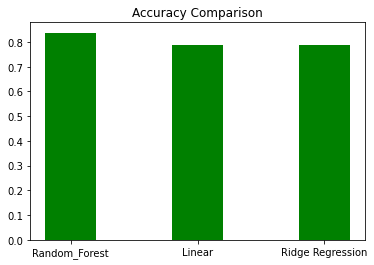

In [51]:
plt.bar(['Random_Forest', 'Linear', 'Ridge Regression'], [arf,alr,arg], width = 0.4, color = 'green')
plt.title("Accuracy Comparison")

In [52]:
rrf = rmse_cv(rf)
rlr = rmse_cv(lr)
rrg = rmse_cv(rg)

<BarContainer object of 3 artists>

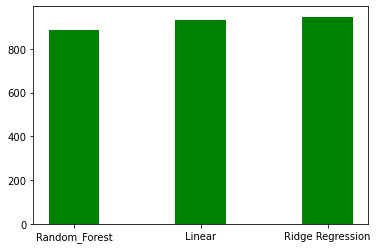

In [53]:
plt.bar(['Random_Forest', 'Linear', 'Ridge Regression'], [rrf,rlr,rrg], width = 0.4, color = 'green')

I have selected Random Forest Regression as our Best Model to predict rentals. As you can see it provides more accuracy and less Root Mean Squared Error(RMSE).
<br>Let's compare the distribution of train and test results. More or less the distribution of train and test looks identical. Looking at the metrics, we can say that our model is not suffering from major overfitting problem.


In [54]:
test_predicted = rf.predict(x_test)
pd.DataFrame(test_predicted,index = y_test.index,columns=['rental']).head(5)

,rental
566,5688.49
374,3339.33
181,5057.38
529,6167.36
233,4632.39


In [55]:
pd.DataFrame(y_test,columns=['rental']).head(5)

,rental
566,5870.0
374,3598.0
181,5362.0
529,7421.0
233,4758.0


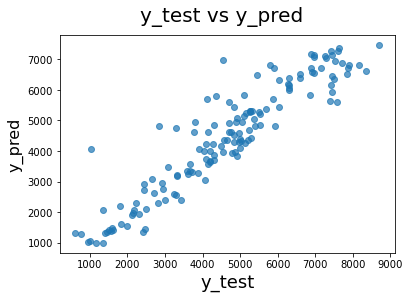

In [56]:
fig = plt.figure()
plt.scatter(y_test, test_predicted, alpha=0.7)
fig.suptitle('y_test vs y_pred', fontsize = 20)              
plt.xlabel('y_test', fontsize = 18)                         
plt.ylabel('y_pred', fontsize = 16) 
plt.show()

## Summary
We can clearly see that, the model is doing quite good on the test data and almost predicting values near to the actual data.
Random Forest is one of the most popular algorithms for regression problems (i.e. predicting continuous outcomes) because of its high accuracy.

The random forest regression algorithm takes advantage of the ‘wisdom of the crowds. It takes multiple (but different) regression decision trees and makes them ‘vote’. Each tree needs to predict the expected number of rentals of on the decision criteria it picked. Random forest regression then calculates the average of all of the predictions to generate a great estimate of what the expected price for a real estate should be.

I will try tuning its hyper parameters such as maximum depth and number of estimators etc. to improve its performance in future.

The main limitation of random forest is that a large number of trees can make the algorithm too slow and ineffective for real-time predictions. If the dataset is huge, you might face problems in deploying the model because of its complexity.
